In [1]:
import ee

In [2]:
import geemap

In [3]:
ee.Authenticate()

MessageError: Error: credential propagation was unsuccessful

**TEMPERATURE**

In [4]:
import numpy as np
import pandas as pd

In [5]:
import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [8]:
import numpy as np
import pandas as pd

dataset=pd.read_csv('Temperature_Sentinal_dataset.csv')
dataset.head()

,Filename,Band1_Mean,Band2_Mean,Band3_Mean,Band4_Mean,Band5_Mean,Band6_Mean,Band7_Mean,Band8_Mean,Band9_Mean,Band10_Mean,Band11_Mean,Band12_Mean,Band13_Mean,Temperature
0,Agri_Land_Temperature_619_2021-06-06.tif_water...,1417.045174,1147.480578,860.596438,565.669875,502.098189,485.323683,490.046855,413.121209,463.311085,101.470774,6.698107,325.263124,254.138988,11.108861
1,Agri_Land_Temperature_619_2021-06-07.tif_water...,1417.045174,1147.480578,860.596438,565.669875,502.098189,485.323683,490.046855,413.121209,463.311085,101.470774,6.698107,325.263124,254.138988,10.785201
2,Agri_Land_Temperature_619_2021-06-08.tif_water...,1417.045174,1147.480578,860.596438,565.669875,502.098189,485.323683,490.046855,413.121209,463.311085,101.470774,6.698107,325.263124,254.138988,10.675139
3,Agri_Land_Temperature_619_2021-06-09.tif_water...,1417.045174,1147.480578,860.596438,565.669875,502.098189,485.323683,490.046855,413.121209,463.311085,101.470774,6.698107,325.263124,254.138988,10.458424
4,Agri_Land_Temperature_619_2021-06-10.tif_water...,1417.045174,1147.480578,860.596438,565.669875,502.098189,485.323683,490.046855,413.121209,463.311085,101.470774,6.698107,325.263124,254.138988,10.251806


Data PreProcessing

In [9]:
dataset.dropna(inplace=True)
dataset.count()

Filename       483
Band1_Mean     483
Band2_Mean     483
Band3_Mean     483
Band4_Mean     483
Band5_Mean     483
Band6_Mean     483
Band7_Mean     483
Band8_Mean     483
Band9_Mean     483
Band10_Mean    483
Band11_Mean    483
Band12_Mean    483
Band13_Mean    483
Temperature    483
dtype: int64

**Random Forest**

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

features = ['Band2_Mean','Band3_Mean','Band4_Mean','Band5_Mean','Band6_Mean','Band7_Mean','Band8_Mean','Band9_Mean']
label = ['Temperature']

X = dataset.loc[:, features].values
y = dataset.loc[:, label].values

#Test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model Development
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_rf_model = grid_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test)

r2_tuned = r2_score(y_test, y_pred_tuned)
rmse_rf=np.sqrt(mean_squared_error(y_test, y_pred_tuned))

#Model Evaluation
print(f'R2 Score : {r2_tuned}')
print(f'RMSE: {rmse_rf}')
print(f'Best Hyperparameters: {best_params}')

rf_model_filename = 'temperature-rf.joblib'
dump(best_rf_model, rf_model_filename)

print(f"Best RandomForestRegressor model saved to {rf_model_filename}")

R2 Score : 0.8132335762450562
RMSE: 1.48397160959567
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RandomForestRegressor model saved to temperature-rf.joblib


 **TOTAL NITROGEN**

In [34]:
import numpy as np
import pandas as pd
from sklearn import metrics
from math import sqrt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import warnings
from joblib import dump
warnings.filterwarnings("ignore")

In [17]:
dataset=pd.read_csv('Nitrogen_Sentinal_dataset.csv')
dataset.head()

,STATION,Date,Band1_Mean,Band2_Mean,Band3_Mean,Band4_Mean,Band5_Mean,Band6_Mean,Band7_Mean,Band8_Mean,Band9_Mean,Band10_Mean,Band11_Mean,Band12_Mean,Band13_Mean,TEST VALUE
0,C1,29-08-2017,1232.0,913.0,688.0,394.0,369.0,393.0,395.0,333.0,339.0,90.0,13.0,74.0,36.0,0.424
1,C1,21-09-2017,1179.0,857.0,622.0,339.0,292.0,268.0,265.0,210.0,205.5,57.0,8.0,50.0,24.0,0.473
2,C1,14-05-2018,1186.0,888.0,674.0,427.5,383.5,347.0,339.0,283.5,295.0,126.5,9.5,160.0,128.0,0.417
3,C1,15-06-2018,1257.0,984.5,794.0,595.0,555.0,532.0,534.5,466.0,500.0,204.5,9.0,365.5,311.5,0.446
4,C1,17-09-2018,1233.0,910.0,642.0,370.0,326.0,308.0,293.0,242.0,235.0,88.0,8.0,62.0,39.0,0.374


**Support Vector Regression**

In [18]:
features = ['Band2_Mean','Band3_Mean','Band4_Mean','Band5_Mean','Band6_Mean','Band7_Mean','Band8_Mean','Band9_Mean']
label = ['TEST VALUE']

X = dataset.loc[:, features].values
y = dataset.loc[:, label].values

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model Developement
svr_model = SVR(kernel='rbf')

param_dist = {
    'C': [x for x in range(1, 10001, 1)],
    'epsilon': [x for x in np.arange(0.001, 1001, 0.001)]
}

random_search = RandomizedSearchCV(SVR(), param_distributions=param_dist, n_iter=200, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

randomDf = pd.DataFrame(random_search.cv_results_)
best_svr_model = random_search.best_estimator_

y_pred = best_svr_model.predict(X_test)

test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
bias = best_svr_model.intercept_

print(f"Best Parameters: {random_search.best_params_}")
print(f"R2 Score: {test_r2}")
print(f"RMSE: {test_rmse}")

svr_model_filename = 'TN-svr.joblib'
dump(best_svr_model, svr_model_filename)

print(f"Best SVR model saved to {svr_model_filename}")

Best Parameters: {'epsilon': 0.097, 'C': 348}
R2 Score: -1.8488485416170755
RMSE: 0.3769725570196915
Best SVR model saved to TN-svr.joblib


**TOTAL PHOSPHORUS**

In [19]:
dataset=pd.read_csv('Phosphorus_Sentinal_dataset.csv')
dataset.head()
dataset.dropna(inplace=True)
print(dataset.count())

SiteID         349
Date           349
Band1_Mean     349
Band2_Mean     349
Band3_Mean     349
Band4_Mean     349
Band5_Mean     349
Band6_Mean     349
Band7_Mean     349
Band8_Mean     349
Band9_Mean     349
Band10_Mean    349
Band11_Mean    349
Band12_Mean    349
Band13_Mean    349
TP             349
dtype: int64


In [21]:
print(dataset.columns)


Index(['SiteID', 'Date', 'Band1_Mean', 'Band2_Mean', 'Band3_Mean',
       'Band4_Mean', 'Band5_Mean', 'Band6_Mean', 'Band7_Mean', 'Band8_Mean',
       'Band9_Mean', 'Band10_Mean', 'Band11_Mean', 'Band12_Mean',
       'Band13_Mean', 'TP'],
      dtype='object')


In [24]:
label = ['TP']

In [28]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming 'dataset' is your DataFrame

# Define features and labels
# Define features and labels
features = ['Band1_Mean', 'Band2_Mean', 'Band3_Mean', 'Band4_Mean', 'Band5_Mean', 'Band6_Mean', 'Band7_Mean', 'Band8_Mean',
            'Band9_Mean', 'Band10_Mean', 'Band11_Mean', 'Band12_Mean', 'Band13_Mean']
label = ['TP']  # Update this line

X = dataset.loc[:, features].values
y = dataset.loc[:, label].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create MLPRegressor
mlp_regressor = MLPRegressor(hidden_layer_sizes=(50000, ), activation='relu', solver='adam', max_iter=500, random_state=42)

# Fit the model
mlp_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred = mlp_regressor.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score on Test Set: {r2}")

mlp_model_filename = 'TP-mlp.joblib'
dump(mlp_regressor, mlp_model_filename)
print(f'MLPRegressor model saved as {mlp_model_filename}')

Mean Squared Error: 0.023354135682960367
R^2 Score on Test Set: 0.30386741857463084
MLPRegressor model saved as TP-mlp.joblib


**pH**

In [30]:
df=pd.read_csv('Ph_Landsat_dataset.csv')
df.head()

,SiteID,Date,Band1_Mean,Band2_Mean,Band3_Mean,Band4_Mean,Band5_Mean,PH
0,BLUE_CHALK,03-06-2015 00:00,0.125024,0.101374,0.074620,0.053516,0.086735,6.77
1,BLUE_CHALK,15-07-2015 00:00,0.178984,0.150875,0.111050,0.084422,0.131796,6.60
2,BLUE_CHALK,28-08-2015 00:00,0.200051,0.168958,0.120381,0.087537,0.130874,6.85
3,BLUE_CHALK,05-11-2015 00:00,0.127767,0.100123,0.060282,0.040461,0.036792,6.66
4,BLUE_CHALK,17-11-2015 00:00,0.214717,0.176831,0.115975,0.093581,0.091780,6.69


In [31]:
df.dropna(inplace=True)
print(df.count())

SiteID        593
Date          593
Band1_Mean    593
Band2_Mean    593
Band3_Mean    593
Band4_Mean    593
Band5_Mean    593
PH            593
dtype: int64


In [32]:
for i in range(1, 6):
    for j in range(1, 6):
        if i!=j:
            new_column_name = f'B{i}_B{j}_Ratio'
            print(new_column_name)
            df[new_column_name] = df[f'Band{i}_Mean'] / df[f'Band{j}_Mean']
# df.head()

B1_B2_Ratio
B1_B3_Ratio
B1_B4_Ratio
B1_B5_Ratio
B2_B1_Ratio
B2_B3_Ratio
B2_B4_Ratio
B2_B5_Ratio
B3_B1_Ratio
B3_B2_Ratio
B3_B4_Ratio
B3_B5_Ratio
B4_B1_Ratio
B4_B2_Ratio
B4_B3_Ratio
B4_B5_Ratio
B5_B1_Ratio
B5_B2_Ratio
B5_B3_Ratio
B5_B4_Ratio


**Support Vector Regression**

In [38]:
features = [
    'Band1_Mean', 'Band2_Mean', 'Band3_Mean', 'Band4_Mean', 'Band5_Mean',
    'B1_B2_Ratio','B1_B3_Ratio','B1_B4_Ratio','B1_B5_Ratio','B2_B1_Ratio','B2_B3_Ratio',
    'B2_B4_Ratio','B2_B5_Ratio','B3_B1_Ratio','B3_B2_Ratio','B3_B4_Ratio','B3_B5_Ratio','B4_B1_Ratio',
    'B4_B2_Ratio','B4_B3_Ratio','B4_B5_Ratio','B5_B1_Ratio','B5_B2_Ratio','B5_B3_Ratio','B5_B4_Ratio'
]

label = ['PH']

X = df.loc[:, features].values
y = df.loc[:, label].values

#Test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model Development
svr_model = SVR(kernel='rbf')

param_dist = {
    'C': [x for x in range(1, 10001, 1)],
    'epsilon': [x for x in np.arange(0.001, 1001, 0.001)]
}

random_search = RandomizedSearchCV(SVR(), param_distributions=param_dist, n_iter=200, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

randomDf = pd.DataFrame(random_search.cv_results_)
best_svr_model = random_search.best_estimator_

y_pred = best_svr_model.predict(X_test)

#Model Evaluation
test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Best Parameters: {random_search.best_params_}")
print(f"R2 Score: {test_r2}")
print(f"RMSE on Test Set: {test_rmse}")

svr_model_filename = 'ph-svr.joblib'
dump(best_svr_model, svr_model_filename)
print(f'Best SVR model saved as {svr_model_filename}')

Best Parameters: {'epsilon': 0.182, 'C': 4322}
R2 Score: 0.5121841409152028
RMSE on Test Set: 0.9078401712010173
Best SVR model saved as ph-svr.joblib


In [39]:
pip install rasterio matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 20.5 MB/s eta 0:00:00


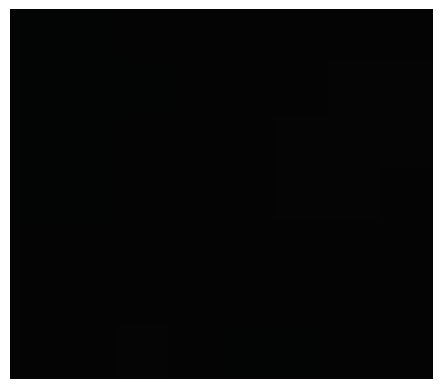

In [40]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Open the Sentinel image file
sentinel_file = "/content/Agri_ceg_2020-05-28.tif"
sentinel_data = rasterio.open(sentinel_file)

# Read the image bands
red = sentinel_data.read(4)
green = sentinel_data.read(3)
blue = sentinel_data.read(2)

# Normalize bands to 0.0 - 1.0
red = red / 65535.0
green = green / 65535.0
blue = blue / 65535.0

# Stack bands to create RGB image
rgb = np.dstack((red, green, blue))

# Display the RGB image
plt.imshow(rgb)
plt.axis('off')  # Turn off axis
plt.show()


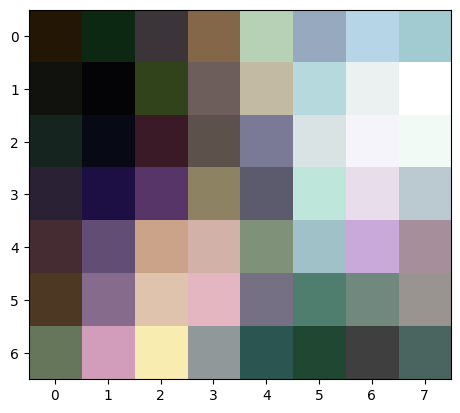

In [41]:
from skimage import exposure

# Apply histogram equalization to each band
red_eq = exposure.equalize_hist(red)
green_eq = exposure.equalize_hist(green)
blue_eq = exposure.equalize_hist(blue)

# Stack bands
rgb_eq = np.dstack((red_eq, green_eq, blue_eq))

# Display the RGB image with equalization
plt.imshow(rgb_eq)


In [44]:
print("Red Band - Min:", red.min(), "Max:", red.max())
print("Green Band - Min:", green.min(), "Max:", green.max())
print("Blue Band - Min:", blue.min(), "Max:", blue.max())


Red Band - Min: 0.0815 Max: 0.1531
Green Band - Min: 0.1082 Max: 0.139
Blue Band - Min: 0.018051422903791865 Max: 0.02153047989623865
